# Multinomial Naïve Bayes Classifier - the YouTube Dataset

### Introducing the database

The database for this example is taken from https://archive.ics.uci.edu/ml/machine-learning-databases/00380/ 

### Importing the necessary libraries

In [88]:
import pandas as pd
import glob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

### Reading the database

In [3]:
files = glob.glob('youtube-dataset/*.csv')
files

['youtube-dataset/Youtube03.csv',
 'youtube-dataset/Youtube02.csv',
 'youtube-dataset/Youtube01.csv',
 'youtube-dataset/Youtube05.csv',
 'youtube-dataset/Youtube04.csv']

In [4]:
all_df = []

for i in files:
    all_df.append(pd.read_csv(i).drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis = 1))

In [8]:
len(all_df[0])

438

In [9]:
data = pd.concat(all_df, axis=0, ignore_index=True)
data

,CONTENT,CLASS
0,"<a href=""http://www.youtube.com/watch?v=KQ6zr6...",0
1,wierd but funny﻿,0
2,"Hey guys, I&#39;m a human.<br /><br /><br />Bu...",1
3,Party Rock....lol...who wants to shuffle!!!﻿,0
4,Party rock﻿,0
...,...,...
1950,SUBSCRIBE TO MY CHANNEL X PLEASE!. SPARE,1
1951,Check out my videos guy! :) Hope you guys had ...,1
1952,3 yrs ago I had a health scare but thankfully ...,1
1953,Rihanna looks so beautiful with red hair ;)﻿,0


In [10]:
data.isnull().sum()

CONTENT    0
CLASS      0
dtype: int64

In [50]:
data['CLASS'].value_counts()

# good since we need around same proportion for multinomial naive bayes

1    1004
0     951
Name: CLASS, dtype: int64

### 0) Explanation of CountVectorizer

In [44]:
message_sample = ['This is a dog and that is a dog', 'This is a cat']

vectorizer_sample = CountVectorizer()

vectorizer_sample.fit_transform(message_sample).toarray()

array([[1, 0, 2, 2, 1, 1],
       [0, 1, 0, 1, 0, 1]])

In [45]:
vectorizer_sample.get_feature_names_out()

array(['and', 'cat', 'dog', 'is', 'that', 'this'], dtype=object)

In [20]:
vectorizer_sample.transform(['Those are birds.']).toarray()

array([[0, 0, 0, 0, 0, 0]])

### 1) Defining the inputs and the target. Creating the train-test split.

In [22]:
inputs = data['CONTENT']
target = data['CLASS']

In [67]:
x_train, x_test, y_train, y_test = train_test_split(inputs, target, 
                                                    test_size=0.2,     # 20% of data for test
                                                    random_state=365,    # set a random seed
                                                    stratify = target) # equal portion of class enter train and test

In [68]:
y_train.value_counts(normalize = True)

1    0.513427
0    0.486573
Name: CLASS, dtype: float64

In [69]:
y_test.value_counts(normalize = True)

1    0.514066
0    0.485934
Name: CLASS, dtype: float64

### 2) Tokenizing the YouTube comments

In [70]:
vectorizer = CountVectorizer()

In [71]:
x_train_transf = vectorizer.fit_transform(x_train)
x_test_transf = vectorizer.transform(x_test)

In [72]:
x_train_transf.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [73]:
vectorizer.get_feature_names_out()

array(['00', '000', '02', ..., 'ｆａｎｃy', 'ｉｓ', 'ｔｈｉｓ'], dtype=object)

In [74]:
x_train_transf.shape

(1564, 3903)

In [75]:
x_test_transf.shape

(391, 3903)

### 3) Performing the classification

In [101]:
clf = MultinomialNB()

# if we want to set our own probability threshold

# clf = MultinomialNB(class_prior=[0.6, 0.4])

clf.fit(x_train_transf, y_train)

MultinomialNB()

In [102]:
np.exp(clf.class_log_prior_)

# we see that probability of ham slightly > spam

array([0.48657289, 0.51342711])

In [103]:
clf.get_params()

# alpha allows to never have a probability of 0 even if we do not see a word in the training set but we do in testing
# just add alpha to both side probability

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

### 4) Performing the evaluation on the test dataset

In [104]:
y_test_pred = clf.predict(x_test_transf)

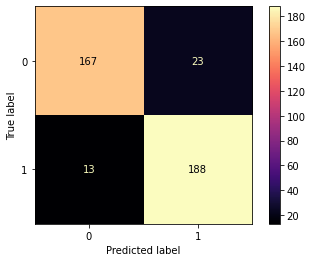

In [105]:
# create the confusion matrix

from sklearn.metrics import ConfusionMatrixDisplay  # Confusion matrix : allow to qtf the perf

sns.reset_orig()

ConfusionMatrixDisplay.from_predictions(
    y_test, y_test_pred,
    labels = clf.classes_,
    cmap = 'magma'
);

# 1.0 = True Negative
# 0.1 = False Positive
# 2.0 = False Negative
# 0.2 = True Positive

In [106]:
from sklearn.metrics import classification_report # Review accuracy / precision...

print(classification_report(y_test, y_test_pred, target_names = ['Ham', 'Spam']))

# accuracy shouldn t be use alone: we do not recognize as easily spam / ham as we can see in confusion matrix

# f1 = harmonic mean of precision and recall 

              precision    recall  f1-score   support

         Ham       0.93      0.88      0.90       190
        Spam       0.89      0.94      0.91       201

    accuracy                           0.91       391
   macro avg       0.91      0.91      0.91       391
weighted avg       0.91      0.91      0.91       391



### Creating probability-distribution figures

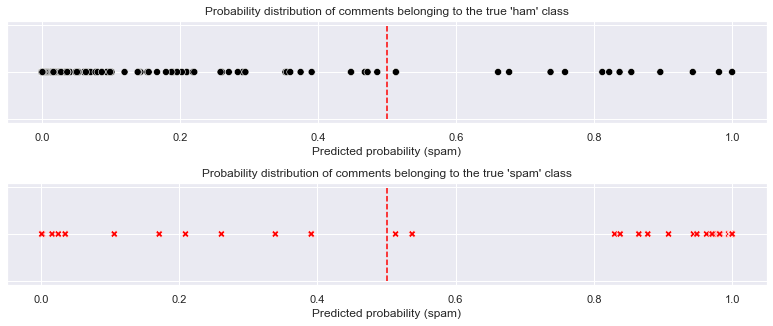

In [107]:
spam_proba = clf.predict_proba(x_test_transf).round(3)[:,1];

df_scatter = pd.DataFrame()

df_scatter['True class'] = y_test
df_scatter['Predicted class'] = y_test_pred
df_scatter['Predicted probability (spam)'] = spam_proba

df_scatter = df_scatter.reset_index(drop = True)

palette_0 = sns.color_palette(['#000000'])
palette_1 = sns.color_palette(['#FF0000'])

df_scatter_0 = df_scatter[df_scatter['True class'] == 0].reset_index(drop = True)
df_scatter_1 = df_scatter[df_scatter['True class'] == 1].reset_index(drop = True)

sns.set()

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,5))
fig.tight_layout(pad = 3)

sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_0.shape[0]), 
                data = df_scatter_0,
                hue = 'True class', 
                s = 50,
                markers = ['o'],
                palette = palette_0,
                style = 'True class',
                legend = False, 
                ax = ax1).set(yticklabels=[])

ax1.set_title('Probability distribution of comments belonging to the true \'ham\' class')
ax1.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');


sns.scatterplot(x = 'Predicted probability (spam)', 
                y = np.zeros(df_scatter_1.shape[0]), 
                hue = 'True class', 
                data = df_scatter_1,
                s = 50,
                palette = palette_1,
                markers = ['X'],
                style = 'True class',
                legend = False, 
                ax = ax2).set(yticklabels=[])

ax2.set_title('Probability distribution of comments belonging to the true \'spam\' class')

ax2.vlines(0.5, -1, 1, linestyles = 'dashed', colors = 'red');



# as we can see that we might change the probability threshold

### Making predictions

In [108]:
predict_data = vectorizer.transform(['This song is amazing!',
                                     'You can win 1m dollars right now, just click here!!!'])

In [109]:
clf.predict(predict_data)

array([0, 1])